# Linear Regression for Time Series

## Aim: Build a simple Linear Model that predicts the LDI index of a country in the future 
### Dataset 
*The OECD dataset merged with vdem dataset has been used for this project with some minor modifications (links for both will be provided below and also in the respository).*

**Description:**
The OECD dataset maintained by the OECD collects data on economic indicators of all the countries over many years. 

### Features
* 1) LDI (Liberal Democracy Index)
* 2) Total ODA (Official Development Assistance) spent for governance purposes by a country
* 3) Total ODA spent by a country
* 4) Purpose codes (for extracting goveranance data)

### Independent Variables 
* LDI index (previous years)
* Total ODA
* Total ODA given to goveranance

### Dependent Variables 
* LDI index (of the future)




In [3]:
# Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt

In [76]:
# Source 
source = "./oda.csv"
save = "./models/"

In [18]:
# Load the data 
data = pd.read_csv(source)

C:\Users\bella\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# Information 
# Getting a hang of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515724 entries, 0 to 1515723
Data columns (total 65 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Unnamed: 0                           1515724 non-null  int64  
 1   Recipient Name                       1515724 non-null  object 
 2   Unnamed: 0_x                         1515724 non-null  int64  
 3   Unnamed: 0.1                         1515724 non-null  int64  
 4   SECTOR                               1515724 non-null  int64  
 5   YEAR                                 1515724 non-null  int64  
 6   Donor Name                           1515724 non-null  object 
 7   Donor Agency                         1515724 non-null  object 
 8   Region                               1515724 non-null  object 
 9   Income Group                         1515724 non-null  object 
 10  Channel of Delivery Code             1515724 non-null  int64  
 11

In [20]:
# Dropping duplicates in the dataset
data.drop_duplicates(subset = ["Recipient Name" , "YEAR"])

,Unnamed: 0,Recipient Name,Unnamed: 0_x,Unnamed: 0.1,SECTOR,YEAR,Donor Name,Donor Agency,Region,Income Group,...,e_pelifeex,e_civil_war,e_pt_coup,e_wbgi_cce,e_wbgi_gee,e_wbgi_pve,e_wbgi_rle,e_wbgi_rqe,e_wbgi_vae,ODA per capita
0,0,Afghanistan,120111,1082,43040,2010,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,59.9,NaN,0.0,-1.636,-1.455,-2.579,-1.845,-1.533,-1.404,0.029264
3104,3104,Afghanistan,438922,425523,15130,2011,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,60.4,NaN,0.0,-1.579,-1.448,-2.502,-1.897,-1.541,-1.336,0.126235
6132,6132,Afghanistan,550462,603981,11130,2012,Belgium,Directorate General for Co-operation and Devel...,South & Central Asia,LDCs,...,60.8,NaN,0.0,-1.420,-1.360,-2.419,-1.643,-1.193,-1.267,0.009504
9141,9141,Afghanistan,700757,779925,11130,2013,Belgium,Directorate General for Co-operation and Devel...,South & Central Asia,LDCs,...,61.3,NaN,0.0,-1.437,-1.385,-2.519,-1.597,-1.193,-1.240,0.002265
11888,11888,Afghanistan,849271,958287,11130,2014,Belgium,Directorate General for Co-operation and Devel...,South & Central Asia,LDCs,...,61.2,NaN,0.0,-1.355,-1.331,-2.411,-1.446,-1.118,-1.135,0.011653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509133,1509133,Zimbabwe,950658,1135284,11240,2015,Belgium,Directorate General for Co-operation and Devel...,South of Sahara,Other LICs,...,59.6,NaN,0.0,-1.310,-1.158,-0.618,-1.318,-1.654,-1.166,0.058309
1510312,1510312,Zimbabwe,1087935,1310356,11240,2016,Belgium,Directorate General for Co-operation and Devel...,South of Sahara,Other LICs,...,60.5,NaN,0.0,-1.259,-1.158,-0.620,-1.368,-1.720,-1.177,0.118850
1511493,1511493,Zimbabwe,1220114,1483410,11240,2017,Belgium,Directorate General for Co-operation and Devel...,South of Sahara,Other LICs,...,61.4,NaN,2.0,-1.273,-1.189,-0.709,-1.378,-1.563,-1.194,0.040813
1512673,1512673,Zimbabwe,1415753,1672181,15160,2018,Sweden,Swedish International Development Authority,South of Sahara,Other LICs,...,61.7,NaN,0.0,-1.235,-1.199,-0.713,-1.273,-1.504,-1.123,0.063834


### Utility functions

In [49]:
# Truncating windows to 
# Functions for array windowing
def create_windowed_arrays(array, window_length=9):
    zipped_array = zip(*[array[i:] for i in range(window_length)])
    return np.array(list(zipped_array))

# Create window truncated X and y 
def create_x_y_truncated(dataset, window_length=9, features_size = 1):
    truncated_dataset = np.array([create_windowed_arrays(array,window_length) for array in dataset])
    truncated_dataset = truncated_dataset.reshape(-1, window_length, features_size)
    return truncated_dataset[:, :-1], truncated_dataset[:, -1:, 2]

In [50]:
# Shufle X and y funciton 
def shuffle_x_y(X, y):
    indices = np.arange(len(X))
    shuffle_indices = np.random.permutation(indices)
    return X[shuffle_indices], y[shuffle_indices]

## Pivot tables to find out cummulative ODA assistance given to each country
Three different pivot tables - one for each of the independent variables must be created 

In [21]:
data.head()

,Unnamed: 0,Recipient Name,Unnamed: 0_x,Unnamed: 0.1,SECTOR,YEAR,Donor Name,Donor Agency,Region,Income Group,...,e_pelifeex,e_civil_war,e_pt_coup,e_wbgi_cce,e_wbgi_gee,e_wbgi_pve,e_wbgi_rle,e_wbgi_rqe,e_wbgi_vae,ODA per capita
0,0,Afghanistan,120111,1082,43040,2010,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,59.9,NaN,0.0,-1.636,-1.455,-2.579,-1.845,-1.533,-1.404,0.029264
1,1,Afghanistan,120112,1083,43040,2010,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,59.9,NaN,0.0,-1.636,-1.455,-2.579,-1.845,-1.533,-1.404,0.117057
2,2,Afghanistan,120113,1084,11120,2010,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,59.9,NaN,0.0,-1.636,-1.455,-2.579,-1.845,-1.533,-1.404,0.476839
3,3,Afghanistan,120114,1085,11120,2010,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,59.9,NaN,0.0,-1.636,-1.455,-2.579,-1.845,-1.533,-1.404,0.000836
4,4,Afghanistan,120115,1086,11220,2010,Denmark,Ministry of Foreign Affairs,South & Central Asia,LDCs,...,59.9,NaN,0.0,-1.636,-1.455,-2.579,-1.845,-1.533,-1.404,0.005096


In [22]:
# Total amount 
total_amount = pd.pivot_table(data, index = ["Recipient Name"], values = "Amount", columns = "YEAR")

In [23]:
# Total Gov amount 
Gov = (data['Purpose Code']>=15110)&(data['Purpose Code']<=15190)
ODAGov = data[Gov]
gov_total_amount = pd.pivot_table(ODAGov, index = ["Recipient Name"], values = "Amount", columns = "YEAR")

In [24]:
# LDI 
ldi = pd.pivot_table(data, index = ["Recipient Name"], values = "v2x_libdem", columns = "YEAR")

In [26]:
# Forming the required data
required_columns = ["Recipient Name" , "v2x_libdem", "Amount", "Purpose Code"]
data = data.loc[:, required_columns]

### Data set clearing 
Check if any values are missing. Remove the country if there is data missing

In [25]:
# Missing values in the dataset
ldi.isna().any(), total_amount.isna().any(), gov_total_amount.isna().any()
# IT seems that the missing values only occur in the year 2010

(YEAR
 2010     True
 2011    False
 2012    False
 2013    False
 2014    False
 2015    False
 2016    False
 2017    False
 2018    False
 2019    False
 dtype: bool,
 YEAR
 2010     True
 2011    False
 2012    False
 2013    False
 2014    False
 2015    False
 2016    False
 2017    False
 2018    False
 2019    False
 dtype: bool,
 YEAR
 2010     True
 2011    False
 2012    False
 2013    False
 2014    False
 2015    False
 2016    False
 2017    False
 2018    False
 2019    False
 dtype: bool)

In [27]:
print(ldi[2010][ldi[2010].isna()== True].index)
print(total_amount[2010][total_amount[2010].isna()== True].index)
print(gov_total_amount[2010][gov_total_amount[2010].isna()== True].index)

Index(['South Sudan'], dtype='object', name='Recipient Name')
Index(['South Sudan'], dtype='object', name='Recipient Name')
Index(['South Sudan'], dtype='object', name='Recipient Name')


In [28]:
# Dropping South Sudan from all of the years 
ldi_cleaned = ldi.drop("South Sudan")
gov_total_amount_cleaned = gov_total_amount.drop("South Sudan")
total_amount_cleaned = total_amount.drop("South Sudan")

### Numpy 
Converting the pandas Series to numpy for further data processing

In [29]:
# Numpy conversion 
total_numpy = total_amount_cleaned.to_numpy()
gov_numpy = gov_total_amount_cleaned.to_numpy()
ldi_numpy = ldi_cleaned.to_numpy()

In [30]:
# ALl have the shape (124, 10)
ldi_numpy.shape

(123, 10)

To predict for the future, we need a dataset in place with all the three feature in accordance with time years

In [31]:
# The sequence must be this way x-> [[[total, amount for Afg], [total , amount for Ang]]] => for year 2000 to 2019]
# y must be [[value for time series Afg, value for time series Ang so on] in 2010 ]

In [32]:
# Making the required dataset 
# Shape required => (10, 124, 2) [10 years, 123 countries, 2 features] # just an example
total_numpy_T = (total_numpy.T)
gov_numpy_T = (gov_numpy.T)

In [33]:
# Shape 
# [countries, time series, 3 features] > batch_size, time_samples, features
dataset = np.c_[gov_numpy.reshape(123, 10, 1), total_numpy.reshape(123, 10, 1), ldi_numpy.reshape(123, 10, 1)]
# []

In [34]:
# X and y division 
time_length = dataset.shape[1] # 10
X = dataset[:, :time_length - 1, :] # 0-8 -> 9years
y = dataset[:, time_length-1, 2] # [gov, amo, ldi]

In [35]:
# Total , gov, LDI
X[56], y[56]

(array([[0.24895241, 0.65477641, 0.346     ],
        [0.24681782, 0.83411701, 0.344     ],
        [0.35924375, 1.03165187, 0.342     ],
        [0.38556713, 1.15930826, 0.384     ],
        [0.36487786, 0.92538841, 0.392     ],
        [0.48443301, 0.93404607, 0.392     ],
        [0.46221733, 0.91160505, 0.39      ],
        [0.61211019, 0.95163896, 0.38      ],
        [0.66367556, 0.80492928, 0.352     ]]),
 0.36200000000001314)

In [36]:
dataset[56]

array([[0.24895241, 0.65477641, 0.346     ],
       [0.24681782, 0.83411701, 0.344     ],
       [0.35924375, 1.03165187, 0.342     ],
       [0.38556713, 1.15930826, 0.384     ],
       [0.36487786, 0.92538841, 0.392     ],
       [0.48443301, 0.93404607, 0.392     ],
       [0.46221733, 0.91160505, 0.39      ],
       [0.61211019, 0.95163896, 0.38      ],
       [0.66367556, 0.80492928, 0.352     ],
       [0.81259975, 0.94765951, 0.362     ]])

### Prediction for year 2021
$y(2021) = m1*(totalODA_2010)+m2*(govODA_2010)+m3*(ld_2010)+ m1*(totalODA_2010)+m2*(govODA_2010)+m3*(ld_2011)+m1*(totalODA_2010)+m2*(govODA_2010)+m3*(ld_2012)+m1*(totalODA_2010)+m2*(govODA_2010)+m3*(ld_2013)+m1*(totalODA_2010)+m2*(govODA_2010)+m3*(ld_2019)
+ c$ 

**31 parameters in total**

### Sample Model
This sample model will consider 10 years data to predict one year in the future. The number of years considered will be tweaked later to obtain optimum performance. 

In [39]:
# Implementing a simple sklearn model 
from sklearn.linear_model import LinearRegression 
lr = LinearRegression()

In [40]:
# Converting the time series into a flattened array with features 
X_sample = X.reshape(-1, 27) #(3*9)

In [41]:
# Training
lr.fit(X_sample, y) # Finding the coefficient and interecept

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
lr.predict(X[120].reshape(1, -1)) # check if it is working 

array([0.04945208])

In [43]:
y[120]

0.04500000000000128

In [44]:
y[0]

0.18700000000000824

In [45]:
X_sample[0] # 9 # 10th year LDI -> y 

array([2.45989424, 2.15002667, 0.222     , 2.84809764, 2.18438161,
       0.223     , 4.3756989 , 2.12483418, 0.224     , 2.60717454,
       1.80648563, 0.221     , 3.02225357, 2.01162727, 0.224     ,
       3.90517013, 2.10781768, 0.227     , 3.98913299, 2.11545536,
       0.201     , 3.27038857, 1.85011457, 0.199     , 2.92117726,
       1.58531098, 0.193     ])

In [46]:
# Calculating the entire RMSE of the sample model 
from sklearn.model_selection import cross_val_score
# If we restrit to one training set -> training bais 
# Trains your model on [entire]=> [1-50], [25-70], [50-100], [75-125]
cross_val_score(lr, X.reshape(123, -1), y, scoring="neg_mean_squared_error") # Error

array([-0.00424725, -0.00261485, -0.00137753, -0.00092924, -0.00749077])

In [47]:
# Checking the rmse for the model 
lr = LinearRegression()
cross_val = cross_val_score(lr, X.reshape(123, -1), y, scoring="neg_mean_squared_error")
print("Average Error is :", np.sqrt(abs(cross_val.mean())))

Average Error is : 0.057722856860090196


In [ ]:
# 123 data points 
# 10 => batches of 4
# []

## Model Building
This model will use only 4 years for Tranining instead of 10 years. The simple reason is the dataset can be artificially increase by truncating techniques. 


### 4 years to predict 1 (2021 -> 2017 to 2019)
* [[1, 2, 3, 4, 5, 6, ,7 , 8, 9, 10]] # Truncating
* [[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7]] 
* [1, 2, 3, 4] => LDI value (next )
2010, 2011, 2012, 2013, 2014 => 2015
2015, 2016, 2017, 2018, 2019 => 2020


In [37]:
# MOdel fixed parameters 
# 4 years 4*3(ldi, oda_amount, total_oda)+1 = 13
# 10 years 10*3+1 = 31 # 123

In [38]:
dataset[0].shape

(10, 3)

In [533]:
# Working of the windowed arrays function
create_windowed_arrays(dataset[0], 4)

array([[[2.45989424, 2.15002667, 0.222     ],
        [2.84809764, 2.18438161, 0.223     ],
        [4.3756989 , 2.12483418, 0.224     ],
        [2.60717454, 1.80648563, 0.221     ]],

       [[2.84809764, 2.18438161, 0.223     ],
        [4.3756989 , 2.12483418, 0.224     ],
        [2.60717454, 1.80648563, 0.221     ],
        [3.02225357, 2.01162727, 0.224     ]],

       [[4.3756989 , 2.12483418, 0.224     ],
        [2.60717454, 1.80648563, 0.221     ],
        [3.02225357, 2.01162727, 0.224     ],
        [3.90517013, 2.10781768, 0.227     ]],

       [[2.60717454, 1.80648563, 0.221     ],
        [3.02225357, 2.01162727, 0.224     ],
        [3.90517013, 2.10781768, 0.227     ],
        [3.98913299, 2.11545536, 0.201     ]],

       [[3.02225357, 2.01162727, 0.224     ],
        [3.90517013, 2.10781768, 0.227     ],
        [3.98913299, 2.11545536, 0.201     ],
        [3.27038857, 1.85011457, 0.199     ]],

       [[3.90517013, 2.10781768, 0.227     ],
        [3.98913299, 2.1

In [51]:
# Using the creaate_x_y_truncated function to shuffle the datasets
random_x, random_y = create_x_y_truncated(dataset, 6, 3)

In [52]:
random_x[0]

array([[2.45989424, 2.15002667, 0.222     ],
       [2.84809764, 2.18438161, 0.223     ],
       [4.3756989 , 2.12483418, 0.224     ],
       [2.60717454, 1.80648563, 0.221     ],
       [3.02225357, 2.01162727, 0.224     ]])

In [53]:
random_y[0] # Future two years

array([0.227])

In [54]:
dataset[0]

array([[2.45989424, 2.15002667, 0.222     ],
       [2.84809764, 2.18438161, 0.223     ],
       [4.3756989 , 2.12483418, 0.224     ],
       [2.60717454, 1.80648563, 0.221     ],
       [3.02225357, 2.01162727, 0.224     ],
       [3.90517013, 2.10781768, 0.227     ],
       [3.98913299, 2.11545536, 0.201     ],
       [3.27038857, 1.85011457, 0.199     ],
       [2.92117726, 1.58531098, 0.193     ],
       [3.47680253, 1.77828519, 0.187     ]])

In [55]:
# 4 years ka data to predicti for next two years
# 4 the data that we know/have

In [56]:
dataset.shape

(123, 10, 3)

In [57]:
# Sampling data to aggregate the data
X_sample, y_sample = create_x_y_truncated(dataset, 4, 3) # This works fine

In [58]:
# Considering the last 5 years for testing on the dataset 
years_considered = 5 # 4 input years -> one output year
X_sample, y_sample = create_x_y_truncated(dataset, years_considered, 3) # Samples considered 
X_sample, y_sample = shuffle_x_y(X_sample, y_sample) # Shuffling Datasets

In [59]:
X_sample.shape

(738, 4, 3)

In [60]:
# Train and test set 
n_sequences = X_sample.shape[0]
train_percentage = 70
train_size = train_percentage*n_sequences // 100
test_size = (100-train_percentage)*n_sequences // 100

In [61]:
# Dividing sets 
X_train, X_test = X_sample[:train_size], X_sample[train_size:]
y_train, y_test = y_sample[:train_size], y_sample[train_size:]

In [62]:
# Make a linear model 
lr = LinearRegression()
lr.fit(X_train.reshape(-1, 4*3), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
# Testing on the validation set 
from sklearn.metrics import mean_squared_error
y_preds = lr.predict(X_test.reshape(-1, 4*3))
rmse = np.sqrt(mean_squared_error(y_preds, y_test))
print("RMSE of when considering the Truncated Dataset: ", rmse)

RMSE of when considering the Truncated Dataset:  0.023626322168838542


In [64]:
# Testing the new model 
n_test_samples = 5

print("Making predictions")
for i in range(n_test_samples):
    random_index  = np.random.randint(X_test.shape[0])
    X_test_case = X_test[random_index].reshape(1, 4*3)
    y_pred =  lr.predict(X_test_case)
    print("Prediction: ", y_pred)
    print("Actual Value: ", y_test[random_index]) 
    print("*"*50)

Making predictions
Prediction:  [[0.62432567]]
Actual Value:  [0.609]
**************************************************
Prediction:  [[0.23321916]]
Actual Value:  [0.207]
**************************************************
Prediction:  [[0.20379953]]
Actual Value:  [0.224]
**************************************************
Prediction:  [[0.10174654]]
Actual Value:  [0.101]
**************************************************
Prediction:  [[0.33541427]]
Actual Value:  [0.324]
**************************************************


In [65]:
# Mannual Test upcoming

In [66]:
dataset[5][:4]

array([[0.20524655, 0.4877848 , 0.191     ],
       [0.30689314, 0.60931415, 0.193     ],
       [0.28933079, 0.45923155, 0.207     ],
       [0.34694921, 0.37149647, 0.212     ]])

In [67]:
dataset[5][4, 2]

0.20799999999999857

In [68]:
lr.predict(np.array([[0.20524655, 0.4877848 , 0.191     ],
       [0.30689314, 0.60931415, 0.193     ],
       [0.28933079, 0.45923155, 0.207     ],
       [0.34694921, 0.37149647, 0.212     ]]).reshape(1, 4*3))

array([[0.21500673]])

In [69]:
# Model Coefficients 
coeffs, intercept = lr.coef_, lr.intercept_
coefs_in_time_series = ["GovAmount", "Amount", "LDI"]*4
coefs_indices = np.asarray([[index+1, index+1, index+1] for index in range(4)]).flatten()
coef_names = [coef_name+"_"+str(index) for coef_name, index in zip(coefs_in_time_series, coefs_indices)]
for coef_name, coef in zip(coef_names, coeffs.flatten()):
    print("{0:15s}: {1:.3f}".format(coef_name, coef))
print("{0:15s}: {1:.3f}".format("Intercept", intercept[0]))

GovAmount_1    : -0.007
Amount_1       : -0.008
LDI_1          : -0.055
GovAmount_2    : 0.012
Amount_2       : -0.004
LDI_2          : 0.228
GovAmount_3    : -0.007
Amount_3       : 0.008
LDI_3          : -0.326
GovAmount_4    : 0.004
Amount_4       : -0.005
LDI_4          : 1.126
Intercept      : 0.013


In [70]:
# Ploting the coefficients 
data_df = np.r_[coeffs.flatten(), list(intercept)]
coef_names_intercept = coef_names + ["Intercept"]
coefs_df = pd.DataFrame(np.c_[data_df, coef_names_intercept], columns = ["Coefficient", "Name"])

In [71]:
# Convert the columns to respective dtypes 
coefs_df["Coefficient"] = coefs_df["Coefficient"].astype(np.float32)
coefs_df["Name"] = coefs_df["Name"].astype(str)

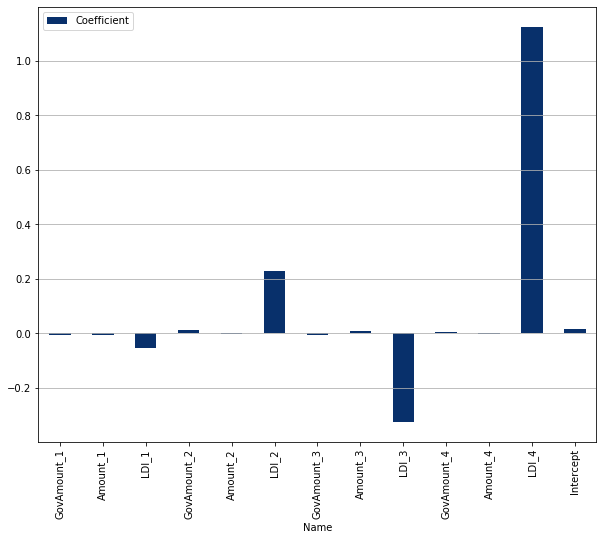

In [72]:
coefs_df.plot(kind="bar", x = "Name", y="Coefficient", cmap="Blues_r", 
             figsize=(10, 8))
plt.grid(axis="y")

In [73]:
# Selected Colors
selected_colors = []
cmap_selected = mpl.cm.get_cmap('Blues_r')
for color_index in range(len(coefs_df)):
    if color_index >= 10:
        selected_colors.append(cmap_selected(3/4))
    else:
        selected_colors.append(cmap_selected(0/4))

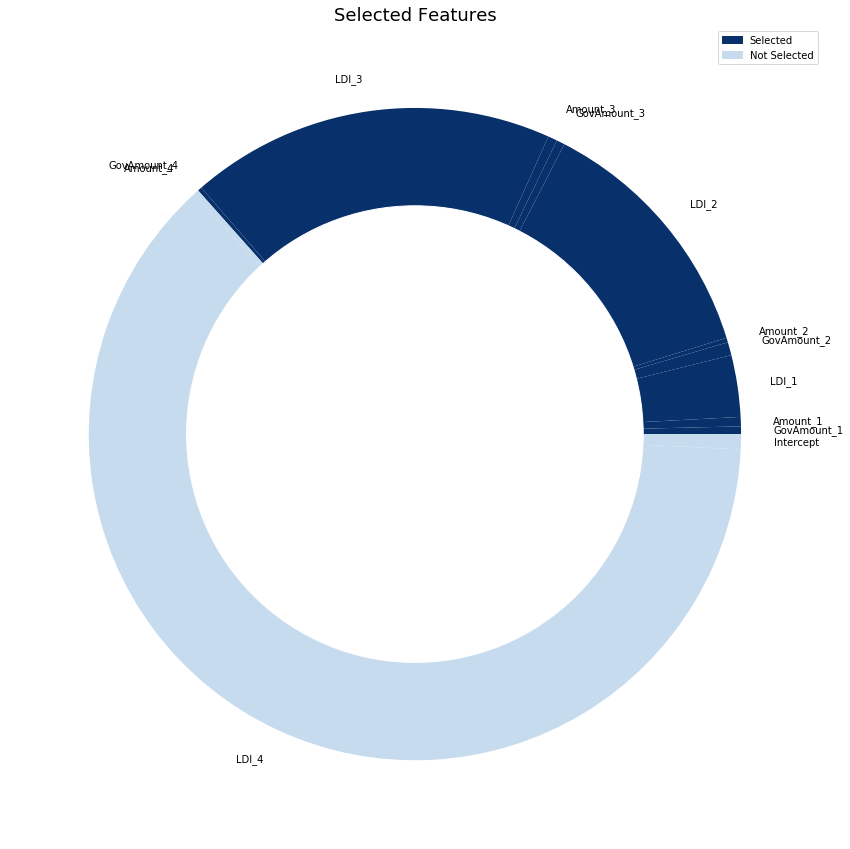

In [74]:
# Donut Chart of the Same
# Selected Features
coefs_abs = coefs_df.copy()
coefs_abs["Coefficient"] = coefs_df["Coefficient"].apply(lambda x: abs(x))
coefs_abs.plot(kind = "pie", y = "Coefficient", 
             subplots = True, 
              labels = coefs_abs["Name"], figsize = (20, 15),
             colors = selected_colors)
plt.ylabel("")
circle = plt.Circle((0, 0), 0.7, color = "white")
ax = plt.gcf().gca()
legend = ax.get_legend()
legend.remove()

ax.add_artist(circle)

plt.title("Selected Features", fontsize = 18)

# Legend
import matplotlib.patches as mpatches
dark_blue = mpatches.Patch(color=cmap_selected(0/4), label='Selected')
light_blue = mpatches.Patch(color = cmap_selected(3/4), label = "Not Selected")
plt.legend(handles=[dark_blue, light_blue], loc = "upper right")
plt.savefig(source+"SelectedFeatures.png")

### Sudan predictions

In [ ]:
# Sudan remove 
# 2014 - 4 years 


In [ ]:
# Between sudan and India
# inmput values 4 years use to predict 

In [348]:
start_year, end_year = 2012, 2016 # We didnt 2021, 22
ss_ldi = ldi.loc["South Sudan", np.arange(start_year, end_year)]
ss_gov_total = gov_total_amount.loc["South Sudan", np.arange(start_year, end_year)]
ss_total_amount = total_amount.loc["South Sudan", np.arange(start_year, end_year)]

In [349]:
test_case = np.c_[ss_total_amount.to_numpy(), ss_gov_total.to_numpy(), ss_ldi.to_numpy() ]

In [350]:
lr.predict(test_case.reshape(1, 4*3)) # 2018

array([[0.07378753]])

In [351]:
ldi.loc["South Sudan", end_year] # 2018 

0.06000000000000116

In [77]:
# Save the models into the models folder 
from joblib import dump, load
model_1_name = save+"model_one_year_into_future.joblib"
dump(lr, model_1_name)

['./models/model_one_year_into_future.joblib']

## Two steps prediction

In [78]:
# Truncating windows to 
# Functions for array windowing
def create_windowed_arrays(array, window_length=9):
    zipped_array = zip(*[array[i:] for i in range(window_length)])
    return np.array(list(zipped_array))

# Create window truncated X and y 
def create_x_y_truncated(dataset, window_length=9, features_size = 1):
    truncated_dataset = np.array([create_windowed_arrays(array,window_length) for array in dataset])
    truncated_dataset = truncated_dataset.reshape(-1, window_length, features_size)
    return truncated_dataset[:, :-2], truncated_dataset[:, -2:, 2]

In [79]:
# Getting shapes
# 6 years => 4 years for input -> 2 years for y 
years_considered = 5
X_sample_two_years, y_sample_two_years = create_x_y_truncated(dataset, years_considered+1, 3) # Samples considered 
# Shuffled dataset
shuffle_indices = np.random.permutation(np.arange(X_sample_two_years.shape[0])) 
X_sample_two_years, y_sample_two_years = X_sample_two_years[shuffle_indices, :, :], y_sample_two_years[shuffle_indices, :]

In [80]:
X_sample_two_years.shape

(615, 4, 3)

In [81]:
# Testand train set
n_sequences = X_sample_two_years.shape[0] # 615
train_percentage = 70 # declaring
train_size = train_percentage*n_sequences // 100 # n_train values
test_size = (100-train_percentage)*n_sequences // 100

# Splitting
X_2_train, X_2_test = X_sample_two_years[:train_size, :], X_sample_two_years[train_size:, :]
y_2_train, y_2_test = y_sample_two_years[:train_size, :], y_sample_two_years[train_size:, :]

In [82]:
X_2_train.shape

(430, 4, 3)

In [83]:
# Linear model 
lr_two_years = LinearRegression()
lr_two_years.fit(X_2_train.reshape(-1, 4*3), y_2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
# RMSE on the test set 
y_preds = lr_two_years.predict(X_2_test.reshape(-1, 4*3))
rmse = np.sqrt(mean_squared_error(y_preds, y_2_test))
print("RMSE of when considering the Truncated Dataset: ", rmse) #.0032

RMSE of when considering the Truncated Dataset:  0.04325627788339275


In [85]:
# Cross validation
cross_val = cross_val_score(lr_two_years, X_sample_two_years.reshape(-1, 4*3), 
                            y_sample_two_years, scoring="neg_mean_squared_error", 
                            cv = 5)
print(np.sqrt(abs(cross_val.mean()))) # Built using the entire dataset -> Very low RMSE

0.04181085925869652


In [89]:
# Testing the new model 
n_test_samples = 5

print("Making predictions")
for i in range(n_test_samples):
    random_index  = np.random.randint(X_test.shape[0])
    X_test_case = X_2_test[random_index].reshape(1, 4*3)
    y_pred =  lr_two_years.predict(X_test_case)
    print("Prediction: ", y_pred)
    print("Actual Value: ", y_2_test[random_index]) 
    print("*"*50)

Making predictions
Prediction:  [[0.1057914  0.10574107]]
Actual Value:  [0.107 0.106]
**************************************************
Prediction:  [[0.59026673 0.58590894]]
Actual Value:  [0.58 0.56]
**************************************************
Prediction:  [[0.21080561 0.21238911]]
Actual Value:  [0.208 0.207]
**************************************************
Prediction:  [[0.39207101 0.38423803]]
Actual Value:  [0.427 0.406]
**************************************************
Prediction:  [[0.22863098 0.2236878 ]]
Actual Value:  [0.244 0.255]
**************************************************


In [90]:
# 613
# dataset => train and test 
# 420 training 
# 190 [4 years => x, 2=>y] test

# 4 input  years 
# 5input year

In [91]:
# Model has to be able to generalize 
# building a model and test (replica of real-world cases)

### Sudan predictions 

In [92]:
start_year, end_year = 2015, 2019
ss_ldi = ldi.loc["South Sudan", np.arange(start_year, end_year)]
ss_gov_total = gov_total_amount.loc["South Sudan", np.arange(start_year, end_year)]
ss_total_amount = total_amount.loc["South Sudan", np.arange(start_year, end_year)]

test_case = np.c_[ss_total_amount.to_numpy(), ss_gov_total.to_numpy(), ss_ldi.to_numpy() ]

print("Prediction: ", lr_two_years.predict(test_case.reshape(1, 4*3))) # 2018

print("Actual Value: ", [ldi.loc["South Sudan", end_year]]) # 2018 

Prediction:  [[0.05038004 0.05950019]]
Actual Value:  [0.06399999999999631]


In [93]:
X_sample_two_years.shape

(615, 4, 3)

In [94]:
dataset[0]

array([[2.45989424, 2.15002667, 0.222     ],
       [2.84809764, 2.18438161, 0.223     ],
       [4.3756989 , 2.12483418, 0.224     ],
       [2.60717454, 1.80648563, 0.221     ],
       [3.02225357, 2.01162727, 0.224     ],
       [3.90517013, 2.10781768, 0.227     ],
       [3.98913299, 2.11545536, 0.201     ],
       [3.27038857, 1.85011457, 0.199     ],
       [2.92117726, 1.58531098, 0.193     ],
       [3.47680253, 1.77828519, 0.187     ]])

### Multi-Target Model Coefficients analysis

In [95]:
# Model Coefficients 
coeffs, intercept = lr_two_years.coef_, lr_two_years.intercept_
coefs_in_time_series = ["GovAmount", "Amount", "LDI"]*4
coefs_indices = np.asarray([[index+1, index+1, index+1] for index in range(4)]).flatten()
coef_names = [coef_name+"_"+str(index) for coef_name, index in zip(coefs_in_time_series, coefs_indices)]
for index, coef in enumerate(coeffs):
    print("Regression Number", index+1)
    for coef_name, coef in zip(coef_names, coef.flatten()):
        print("{0:15s}: {1:.3f}".format(coef_name, coef))
    print("{0:15s}: {1:.3f}".format("Intercept", intercept[index]))
    print("*"*50)

Regression Number 1
GovAmount_1    : -0.010
Amount_1       : 0.007
LDI_1          : -0.008
GovAmount_2    : 0.014
Amount_2       : -0.018
LDI_2          : 0.251
GovAmount_3    : -0.008
Amount_3       : 0.011
LDI_3          : -0.409
GovAmount_4    : 0.005
Amount_4       : -0.005
LDI_4          : 1.147
Intercept      : 0.008
**************************************************
Regression Number 2
GovAmount_1    : -0.014
Amount_1       : 0.005
LDI_1          : -0.009
GovAmount_2    : 0.014
Amount_2       : -0.024
LDI_2          : 0.250
GovAmount_3    : 0.003
Amount_3       : 0.014
LDI_3          : -0.502
GovAmount_4    : -0.001
Amount_4       : -0.006
LDI_4          : 1.221
Intercept      : 0.017
**************************************************


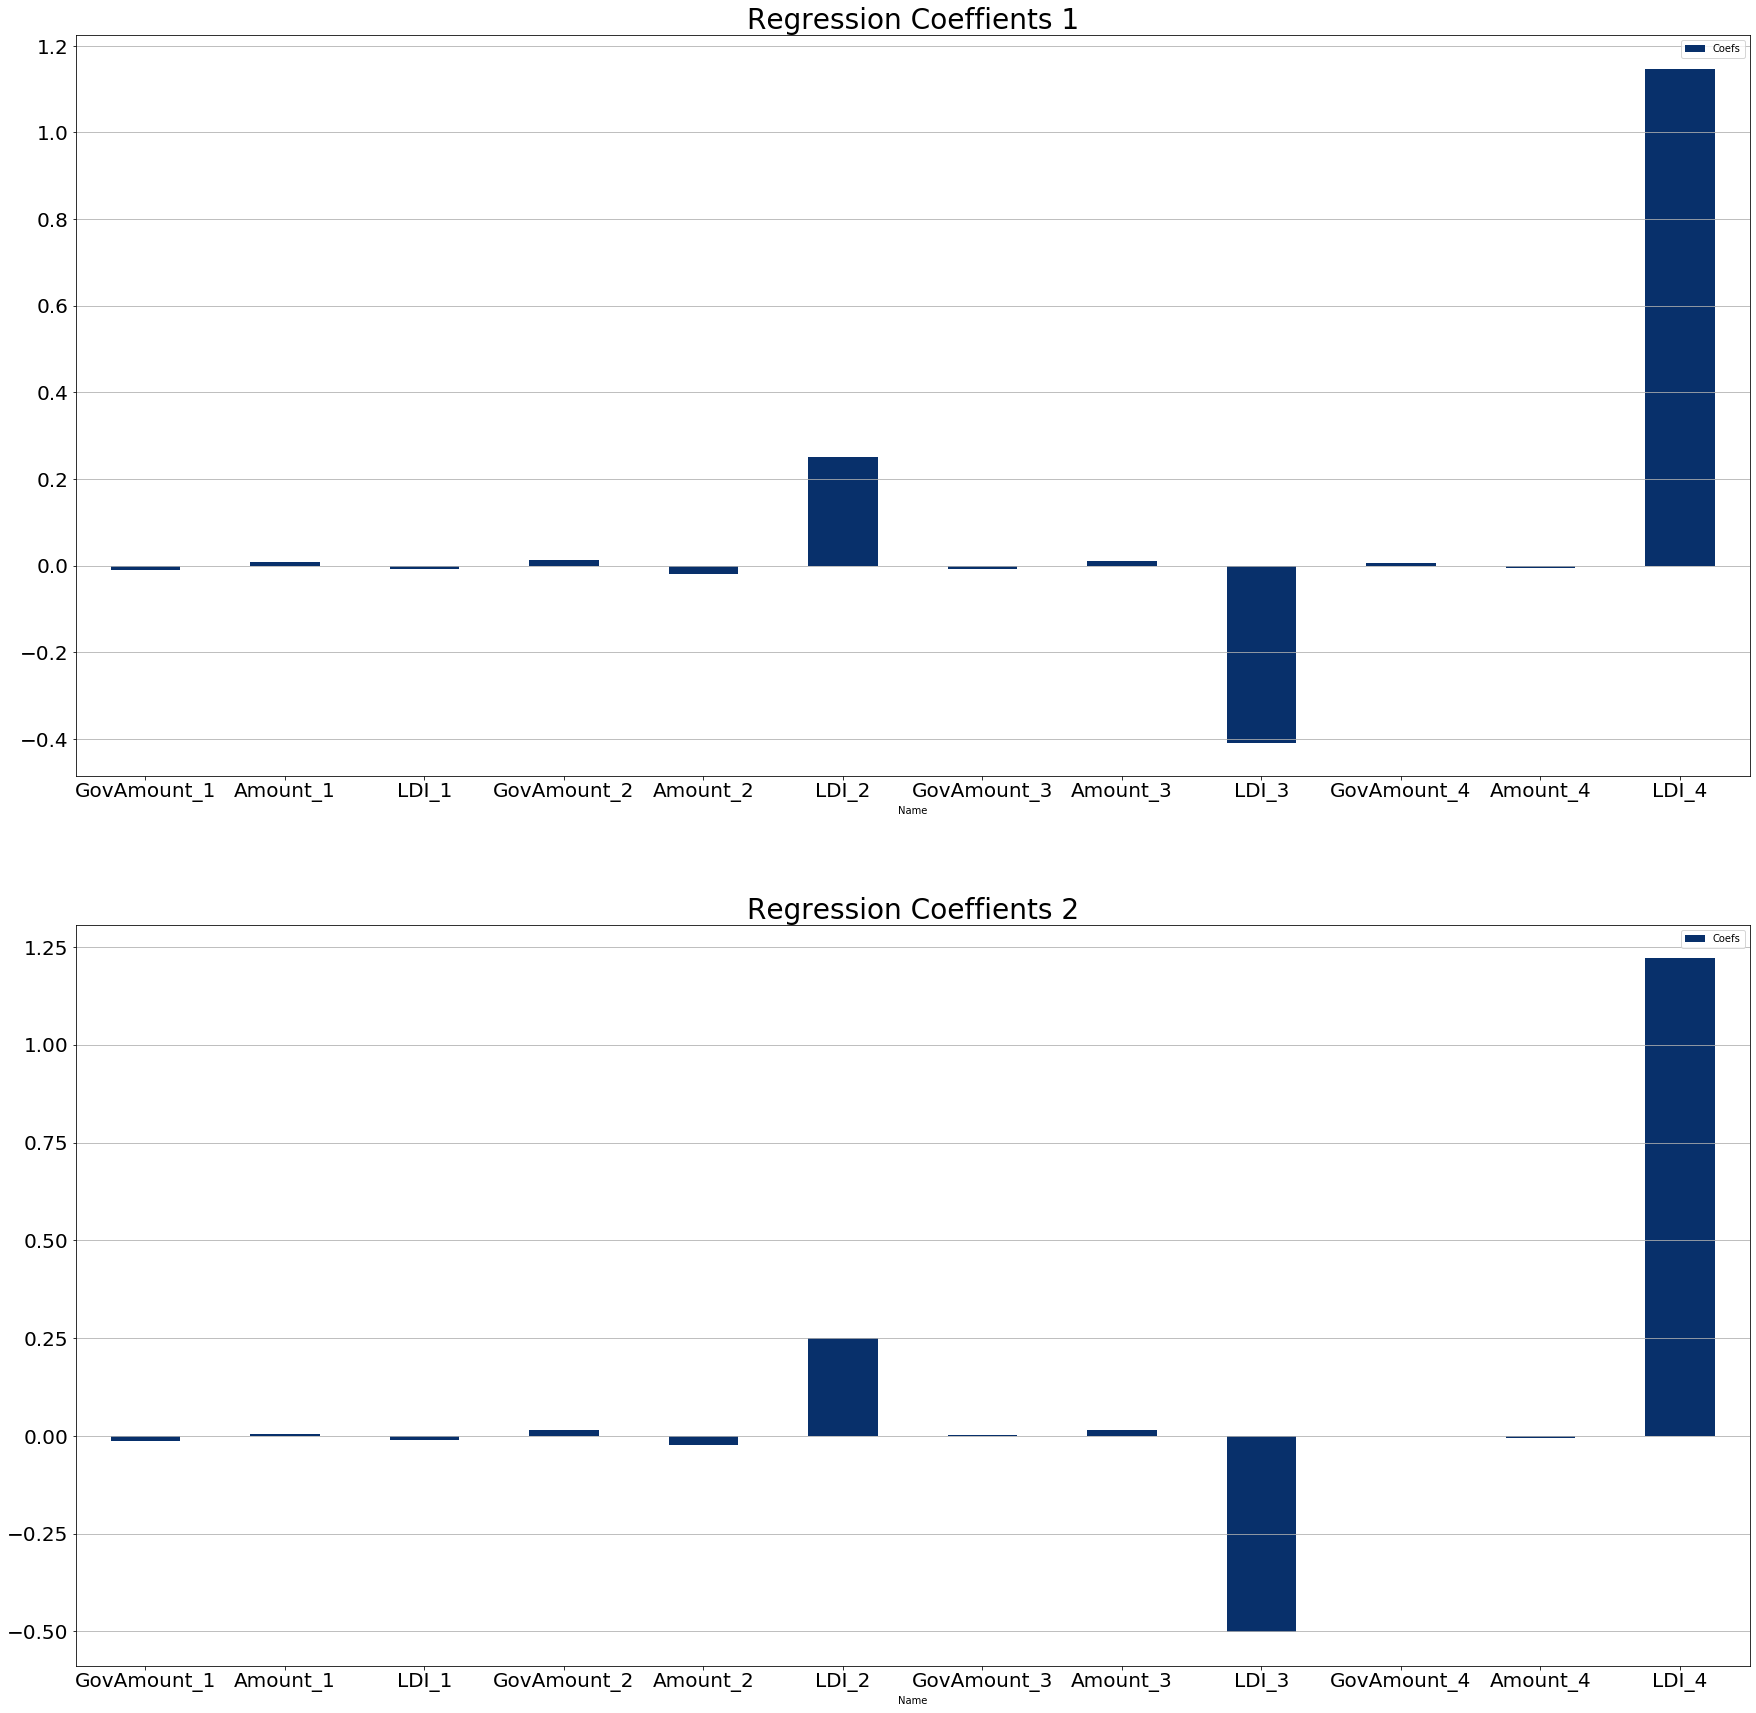

In [151]:
# Plot the coefficients 
fig, axes = plt.subplots(2, 1, figsize=(30, 30))
for index, axis in enumerate(axes):
    coef_data = np.c_[coef_names, coeffs[index].flatten()]
    coef_df = pd.DataFrame(coef_data, columns=["Name", "Coefs"])
    coef_df["Coefs"] = coef_df["Coefs"].astype(np.float32)
    coef_df.plot(kind="bar", y = "Coefs", x="Name", ax=axis, 
                cmap = "Blues_r", fontsize = 20)
    axis.grid(axis="y")
    axis.set_title("Regression Coeffients "+str(index+1), fontsize=28)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=360)
plt.savefig("./images/RegressionCoefficients.png")

### *One Year in the future*
$ldi_{5} =  -0.009 * gov_{1} - 0.001 * amo_{1} - 0.070 * ldi_{1}
            +0.013 * gov_{2} - 0.006 * amo_{2} + 0.213 * ldi_{2}
            -0.008 * gov_{3} - 0.008 * amo_{3} - 0.253 * ldi_{3}
            +0.006 * gov_{4} - 0.011 * amo_{4} + 1.092 * ldi_{4} + 0.012
$

### *Two Years in the future*
$ldi_{6} =  -0.007 * gov_{1} - 0.006 * amo_{1} + 0.014 * ldi_{1}
            +0.010 * gov_{2} - 0.010 * amo_{2} + 0.103 * ldi_{2}
            -0.004 * gov_{3} - 0.011 * amo_{3} - 0.271 * ldi_{3}
            -0.004 * gov_{4} - 0.014 * amo_{4} + 1.107 * ldi_{4} + 0.027
$

In [97]:
# Downloading the model 
model_2_name = "model_two_years_into_future.joblib"
dump(lr, save+model_2_name)

['./models/model_two_years_into_future.joblib']

In [98]:
# LR with on the eniter dataset
# X_sample_two_years is the entire X => 630
# y_sample_two_years is the entire y => 630

In [104]:
# Predicting the LDI for all the countries in year 2021
dataset.shape

(123, 10, 3)

In [105]:
# Predictions on the entire dataset 
X_final = dataset[:, -4:, :] # Doesnt have y final 

In [110]:
# Predictions 
y_final_preds = lr_two_years.predict(X_final.reshape(-1, 4*3))

In [111]:
y_final_preds[0]

array([0.17893166, 0.16859905])

In [112]:
y_final_preds.shape # [:, -4:, :]

(123, 2)

In [113]:
y_final_preds[:, 0]

array([ 0.17893166,  0.40834365,  0.14686938,  0.20632938,  0.59169324,
        0.64912653,  0.06721314,  0.08965542,  0.11669544,  0.38866659,
        0.47712361,  0.31361872,  0.34900839,  0.55530657,  0.51171137,
        0.51601284,  0.26384645,  0.06282835,  0.06811103,  0.12201593,
        0.69327674,  0.21091547,  0.11154487,  0.05182701,  0.47802215,
        0.18933899,  0.84442447,  0.11948657,  0.14571505,  0.13182033,
        0.27615549,  0.43974558,  0.13964088,  0.45856386,  0.06143079,
        0.01349545,  0.11756618,  0.17085295,  0.27383543,  0.2138404 ,
        0.50219617,  0.59445794,  0.42010582,  0.17810228,  0.34254514,
        0.45713828,  0.23954404,  0.23820231,  0.35127092,  0.45531514,
        0.14769762,  0.25414476,  0.34076593,  0.69173532,  0.23503573,
        0.13251503,  0.36752718,  0.40795075,  0.31392477,  0.11223037,
        0.28524607,  0.4804617 ,  0.4382758 ,  0.15662939,  0.26379097,
        0.40118359,  0.30927284,  0.36847049,  0.32979672,  0.17

In [127]:
# Make a table of next two predictions 
ldi_final = pd.DataFrame(ldi)
ldi_final  = ldi_final.drop("South Sudan")
ldi_final[2020] = y_final_preds[:, 0]
ldi_final[2021]  =y_final_preds[:, 1]

In [146]:
ldi_final.head()

YEAR,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Recipient Name,,,,,,,,,,,,
Afghanistan,0.222,0.223,0.224,0.221,0.224,0.227,0.201,0.199,0.193,0.187,0.178932,0.168599
Albania,0.444,0.444,0.441,0.421,0.431,0.433,0.433,0.430,0.421,0.407,0.408344,0.405310
Algeria,0.159,0.160,0.163,0.166,0.165,0.167,0.161,0.155,0.156,0.145,0.146869,0.149615
Angola,0.165,0.164,0.164,0.163,0.163,0.163,0.164,0.178,0.205,0.211,0.206329,0.208248
Argentina,0.599,0.594,0.591,0.590,0.607,0.600,0.622,0.609,0.625,0.605,0.591693,0.583880


### Final Report 

In [132]:
# Downloading predictions for the future and exploring them 
predictions_path = "./predictions/predictions.csv"
ldi_final.to_csv(predictions_path)

Text(0.5, 1.0, 'Average LDI per year')

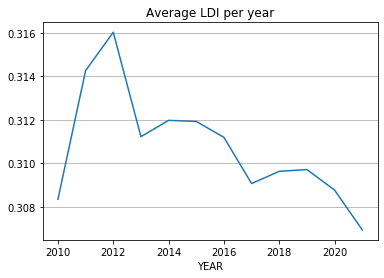

In [145]:
# Exploring the predictions 
mean_ldi_per_year = ldi_final.mean()
ax = mean_ldi_per_year.plot(kind="line")
ax.grid(axis="y")
ax.set_title("Average LDI per year")

It seems that the average ldi score is decreasing for a few years. The model predicts that this trend will continue

### *One Year in the future*
$ldi_{5} =  -0.009 * gov_{1} - 0.001 * amo_{1} - 0.070 * ldi_{1}
            +0.013 * gov_{2} - 0.006 * amo_{2} + 0.213 * ldi_{2}
            -0.008 * gov_{3} - 0.008 * amo_{3} - 0.253 * ldi_{3}
            +0.006 * gov_{4} - 0.011 * amo_{4} + 1.092 * ldi_{4} + 0.012
$

### *Two Years in the future*
$ldi_{6} =  -0.007 * gov_{1} - 0.006 * amo_{1} + 0.014 * ldi_{1}
            +0.010 * gov_{2} - 0.010 * amo_{2} + 0.103 * ldi_{2}
            -0.004 * gov_{3} - 0.011 * amo_{3} - 0.271 * ldi_{3}
            -0.004 * gov_{4} - 0.014 * amo_{4} + 1.107 * ldi_{4} + 0.027
$

## Sources
1) OECD Dataset from OECD stats (https://stats.oecd.org/)